# DA24C024: DAL 8

In [96]:
#importing basic libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [97]:
#code to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [98]:
#Creating the dataset
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

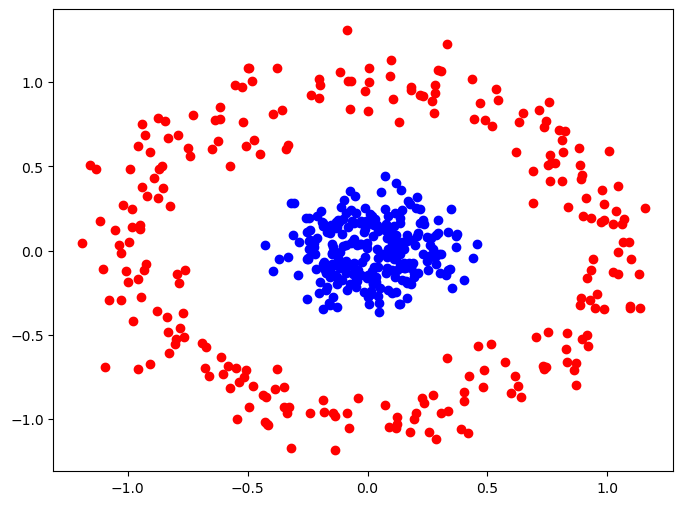

In [99]:
#visualizing the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 1][:, 0], X[y== 1][:, 1], color='b', label='Class 1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='r', label='Class -1')

TASK 1: Implementing AdaBoost from scratch

In [100]:
#AdaBoost class that inhertits BaseEstimator and ClassifierMixin

class AdaBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model=None, n_estimators=50, learning_rate=0.5):
        self.base_model = base_model if base_model is not None else DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.alphas = []
        self.models = []
        
    def fit(self, X, y, X_test=None, y_test=None):
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples

        for t in range(self.n_estimators):
            model = clone(self.base_model)
            try:
                model.fit(X, y, sample_weight=w)
            except TypeError: #except because some classifiers donot support sample weights
                model.fit(X, y)

            y_pred = model.predict(X)

            # Compuinge error and alpha/importance of the weak classifier
            error = np.sum(w * (y != y_pred)) / np.sum(w)
            alpha = self.learning_rate * np.log((1 - error) / (error + 1e-10))
            self.alphas.append(alpha)
            self.models.append(model)

            w *= np.exp(alpha * (y != y_pred)) #weight updation
            
            #at the last iteration we plot decision boundaries at all previous iteration and final iteration
            if X_test is not None and y_test is not None:
                if t==self.n_estimators-1:
                    self.plot_decision_boundary(X_test, y_test, t + 1)
                    self.plot_all_decision_boundaries(X,y)

    def predict(self, X): #predict fn
        final_pred = np.zeros(X.shape[0])
        for alpha, model in zip(self.alphas, self.models):
            final_pred += alpha * model.predict(X)
        return np.sign(final_pred)

    def plot_decision_boundary(self, X, y, iteration): #for plotting the decision boundary at current iteration
        plt.figure(figsize=(8, 6))

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
        plt.title(f"Decision Boundary at Iteration {iteration}")
        plt.show()

    
    def plot_all_decision_boundaries(self, X, y):  #for plotting the decision boundary at all iterations
        plt.figure(figsize=(8, 6))
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))

        for i, (alpha, model) in enumerate(zip(self.alphas, self.models)):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, alpha=0.3, levels=[0], linestyles=["--"], colors=[plt.cm.viridis(i / self.n_estimators)])

        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
        plt.title("All Decision Boundaries from Iterations")
        plt.show()




Checking AdaBoost on Decision Stump


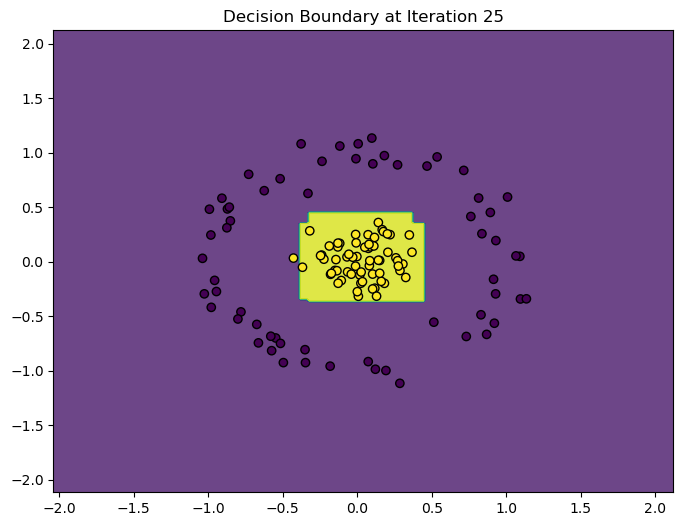

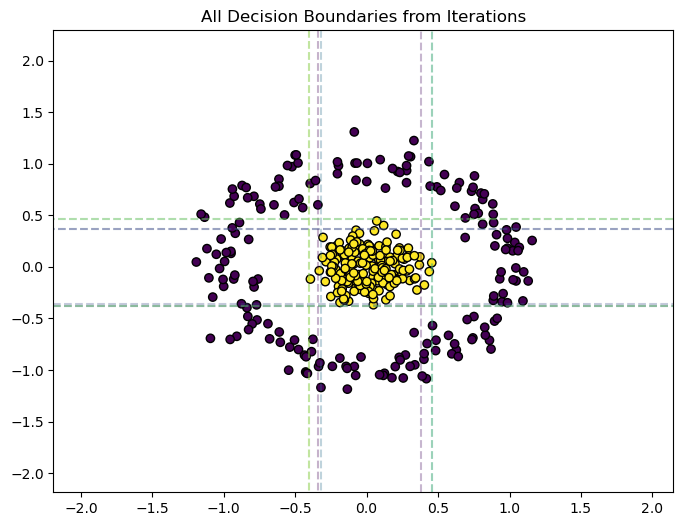

Final Accuracy: 0.992


In [101]:
#Testing the classifier on decision stump
model = AdaBoostClassifier(base_model=DecisionTreeClassifier(max_depth=1), n_estimators=25, learning_rate=0.5)
print("Checking AdaBoost on Decision Stump")
model.fit(X_train, y_train, X_test=X_test, y_test=y_test)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {accuracy}")

TASK 2: AdaBoost implementation with several weak classifiers

In [102]:
#importing libraries and models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [103]:
#Preprocessing Data: SCaling
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
poly= PolynomialFeatures(degree=2, include_bias=False)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)


In [104]:
#Functions to plot Decision Boundaries

#final decision boundaries
def plot_decision_boundary(X, y, model, poly):
    plt.figure(figsize=(8,6))
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_poly = poly.transform(grid_points)
    
    Z = model.predict(grid_points_poly)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')
    plt.title(f"Decision Boundary {model}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

#decision boundary at all iterartions
def plot_all_decision_boundaries(X, y, models, polys, n_estimators=10):

    plt.figure(figsize=(8,6))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    for i, (model, poly) in enumerate(zip(models, polys)):
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_points_poly = poly.transform(grid_points)

        Z = model.predict(grid_points_poly)
        Z = Z.reshape(xx.shape)
        
        plt.contour(xx, yy, Z, alpha=0.3, levels=[0], 
                    linestyles=["--"], 
                    colors=[plt.cm.viridis(i / n_estimators)])
    
    # Plot the original data points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')
    plt.title("All Decision Boundaries from Ensemble")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


In [105]:
#defining weak classifiers and their parameter grids
weak_classifiers = [
    ("Logistic Regression", LogisticRegression(solver='saga',max_iter=200, penalty='l2'),{}),
    ("Decision Stump", DecisionTreeClassifier(max_depth=1), {}),
    ("Decision Tree (depth=3)", DecisionTreeClassifier(max_depth=3), {}),
    ("Linear SVM", SVC(kernel='linear'), {}),
    ("LDA", LDA(), {})
]

# GridSearch for AdaBoost hyperparameters
ada_boost_param_grid = {
    'n_estimators': [1, 10, 25, 50],
    'learning_rate': [0.1, 0.5, 1.0]
}


Using Weak Classifier: Logistic Regression
Best Parameters for Logistic Regression with AdaBoost: {'learning_rate': 0.1, 'n_estimators': 1}
Logistic Regression Train Accuracy: 1.0
Logistic Regression Test Accuracy: 1.0




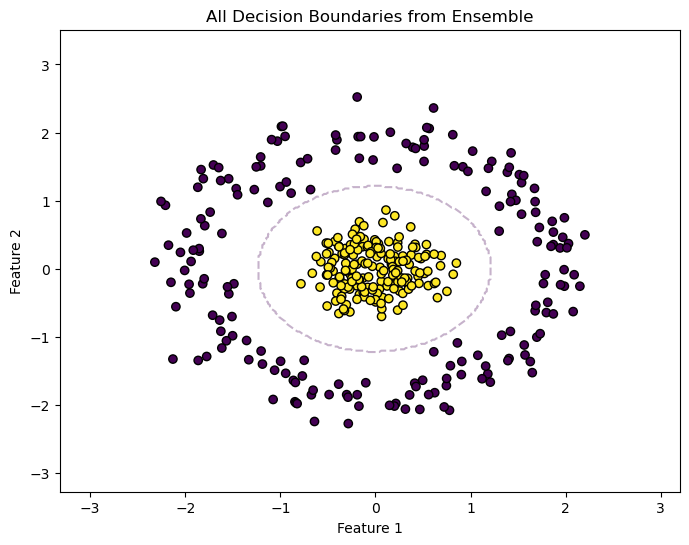

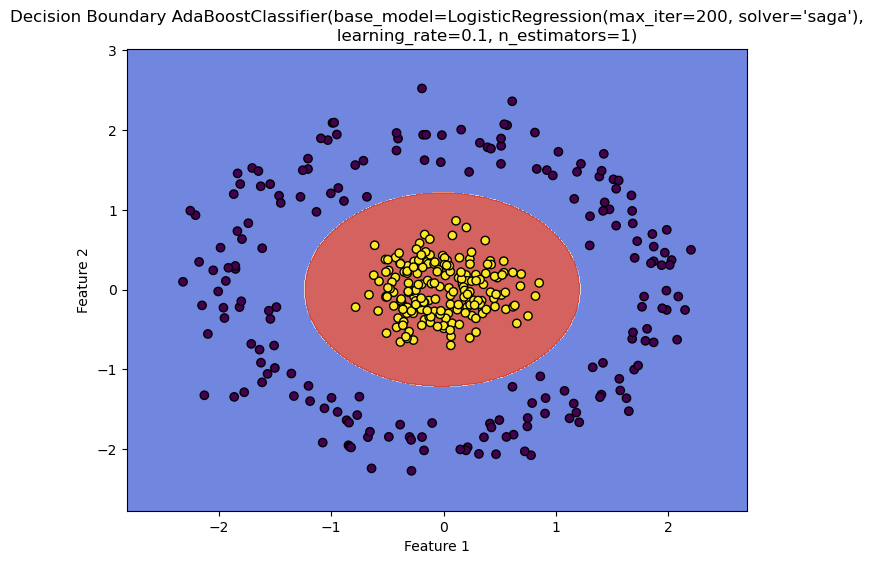

Using Weak Classifier: Decision Stump
Best Parameters for Decision Stump with AdaBoost: {'learning_rate': 0.1, 'n_estimators': 50}
Decision Stump Train Accuracy: 1.0
Decision Stump Test Accuracy: 1.0




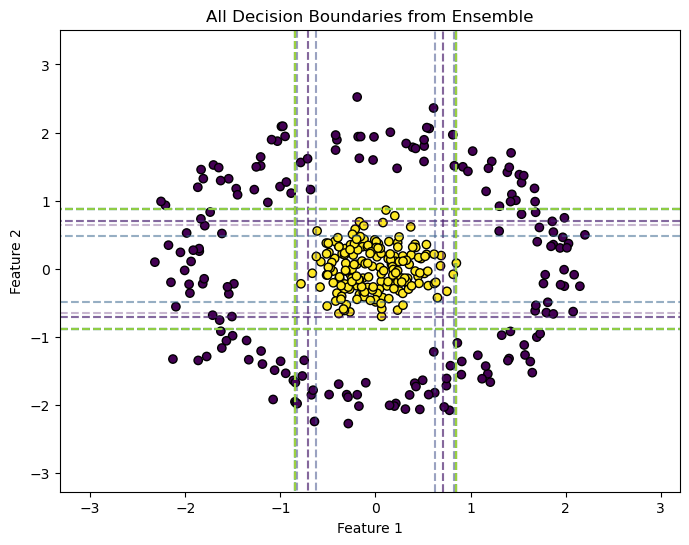

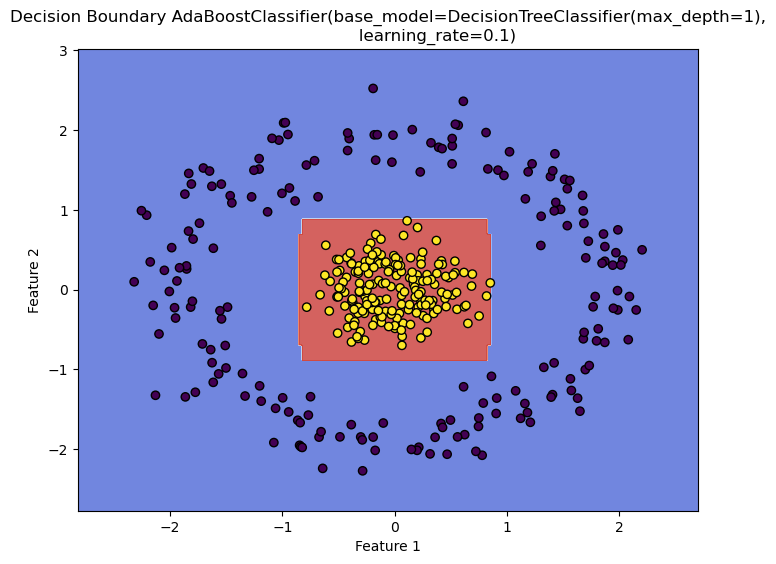

Using Weak Classifier: Decision Tree (depth=3)
Best Parameters for Decision Tree (depth=3) with AdaBoost: {'learning_rate': 0.1, 'n_estimators': 10}
Decision Tree (depth=3) Train Accuracy: 1.0
Decision Tree (depth=3) Test Accuracy: 1.0




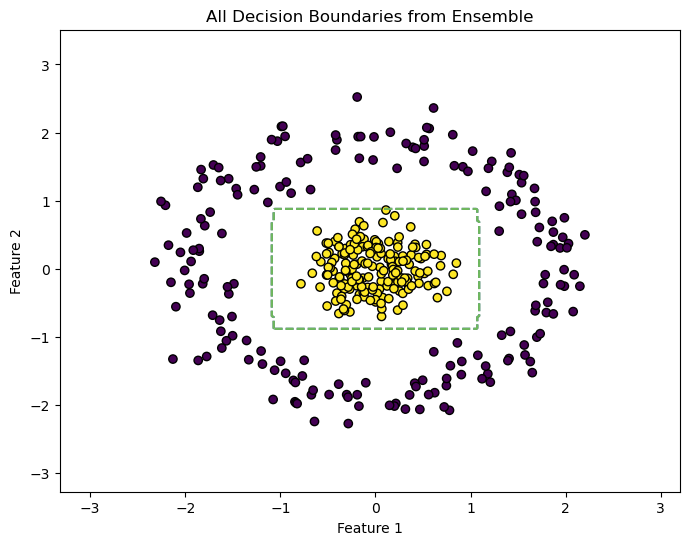

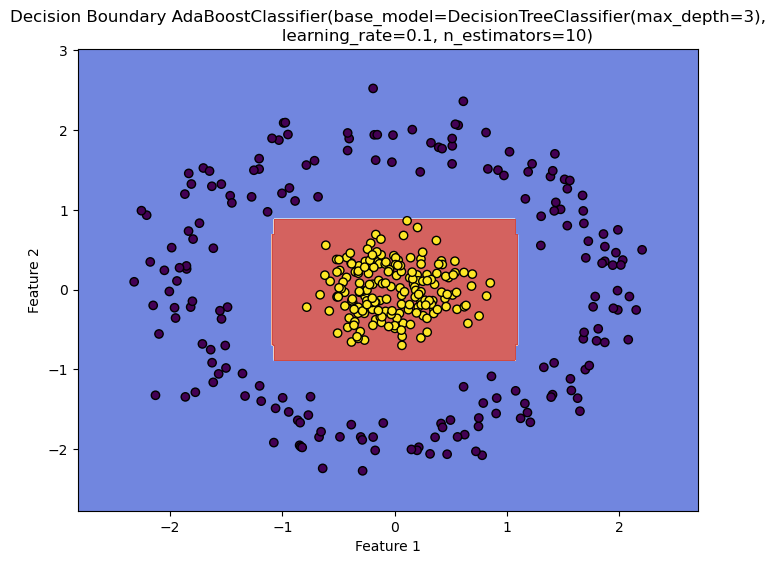

Using Weak Classifier: Linear SVM
Best Parameters for Linear SVM with AdaBoost: {'learning_rate': 0.5, 'n_estimators': 10}
Linear SVM Train Accuracy: 1.0
Linear SVM Test Accuracy: 1.0




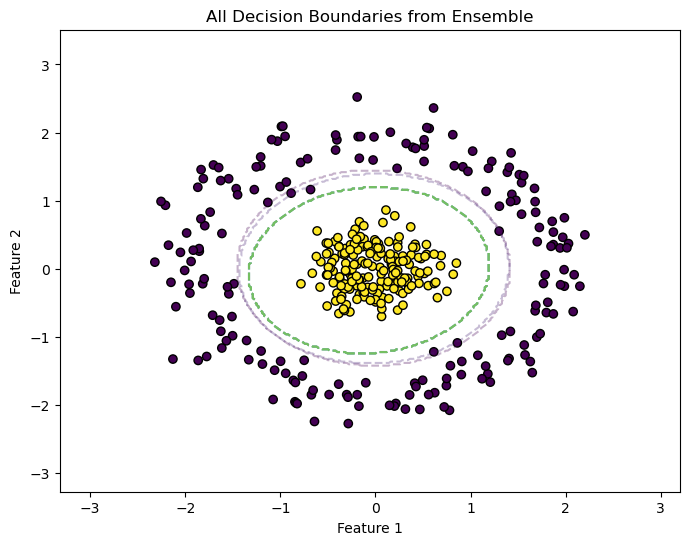

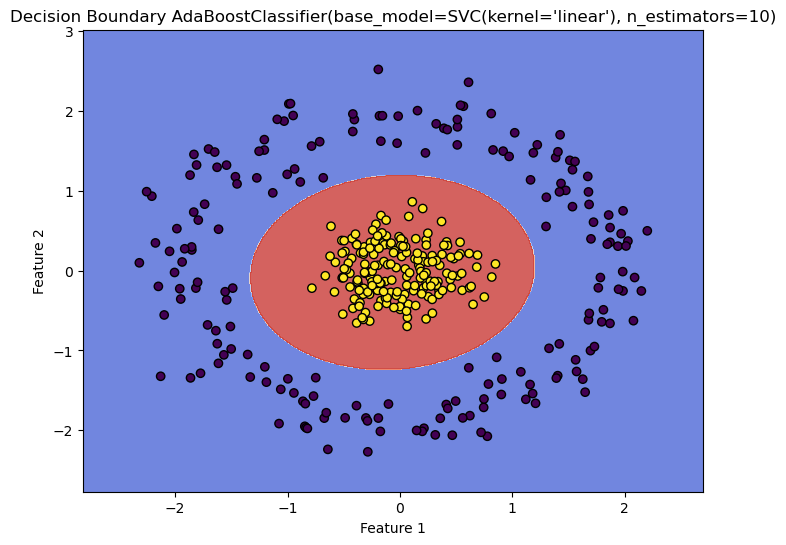

Using Weak Classifier: LDA
Best Parameters for LDA with AdaBoost: {'learning_rate': 0.1, 'n_estimators': 1}
LDA Train Accuracy: 0.992
LDA Test Accuracy: 0.992




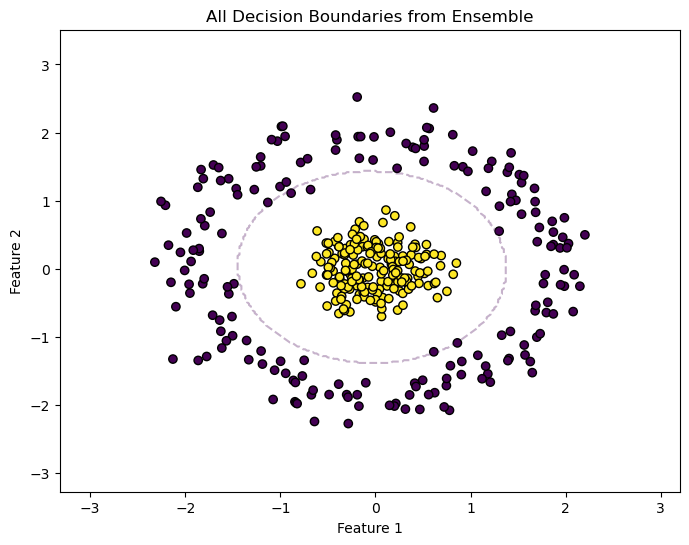

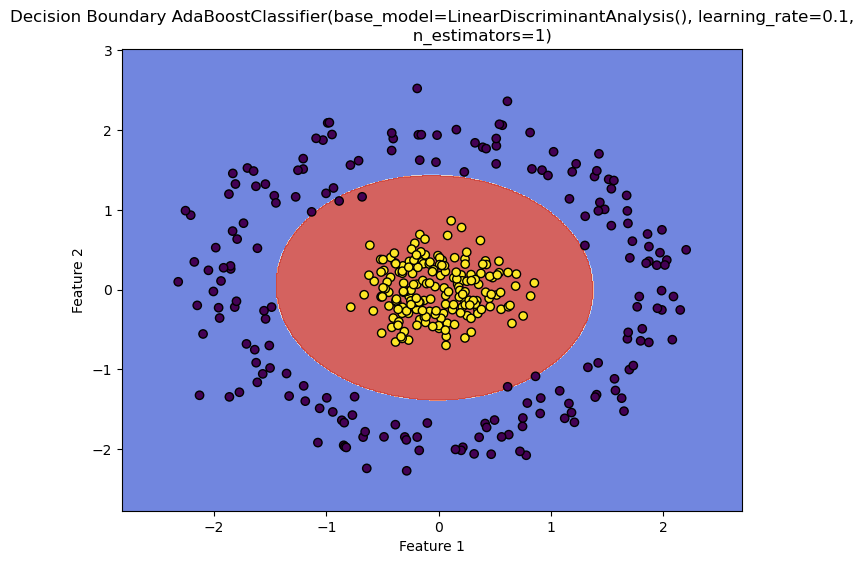

In [106]:
#performing gridsearch
for name, clf, clf_param_grid in weak_classifiers:
    print(f"Using Weak Classifier: {name}")
    
    # for tuning weak classifier parameters
    weak_clf_grid_search = GridSearchCV(clf, clf_param_grid, cv=5, scoring='accuracy')
    weak_clf_grid_search.fit(X_train, y_train)
    best_weak_clf = weak_clf_grid_search.best_estimator_

    # for tuning AdaBoost parameters
    ada_boost = AdaBoostClassifier(base_model=best_weak_clf)
    grid_search = GridSearchCV(ada_boost, ada_boost_param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Best parameters for AdaBoost
    best_params = grid_search.best_params_
    print(f"Best Parameters for {name} with AdaBoost: {best_params}")

    best_model = grid_search.best_estimator_

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print(f"{name} Train Accuracy: {accuracy_train}")
    print(f"{name} Test Accuracy: {accuracy}\n\n")

    # Plot all decision boundaries and final decision boundary for AdaBoost on training data
    plot_all_decision_boundaries(X_train, y_train, best_model.models, [poly]*len(best_model.models), n_estimators=best_model.n_estimators)
    plot_decision_boundary(X_train, y_train, best_model, poly)



So, we achieve > 99% accuracy for all weak classifiers